## Panel Estimators for AB Tests with Repeated Observations

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import pyfixest as pf
from pyfixest.utils.dgps import get_sharkfin

In this tutorial, we show how to use pyfixest to reduce the variance of your estimators in AB tests with repeated observations.

For example, we may be a streaming platform and we want to estimate the effect of a new feature on the amount of time users spend watching videos. To do so, 
we randomly assign the treatment to half of our users. For 15 days prior to the experiment, we track the desired outcome (minutes watched) for each user. If
users are not seen on the platform on a given day, the number of minutes watched is 0. Our experiment runs for 15 days. All in all, we have 30 days of data for each 
user. 

To get started, we simulate a panel data set of 100_000 users, with mentioned 30 days of data, with 15 days of pre and post data. 

In [2]:
def get_data(num_units: int, sigma_unit: int) -> pd.DataFrame:
    """
    Random example data set.
    num_units: int
        The number of users
    sigma_unit: int
        The user-level idosyncratic error term.
    """
    data = get_sharkfin(
        num_units=100_000,
        num_periods=30,
        num_treated=500,
        treatment_start=15,
        seed=231,
        sigma_unit=18,
    )
    data = data.rename(columns={"Y": "minutes_watched", "unit": "user", "year": "day"})

    return data


data = get_data(num_units=100_000, sigma_unit=18)
data.head()

,user,day,treat,minutes_watched,ever_treated
0,0,0,0,8.114488,0
1,0,1,0,7.633058,0
2,0,2,0,6.712332,0
3,0,3,0,6.230820,0
4,0,4,0,6.004489,0


We can inspect the data generating process via the `panelview()` function: 

<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Day', ylabel='Cohort'>

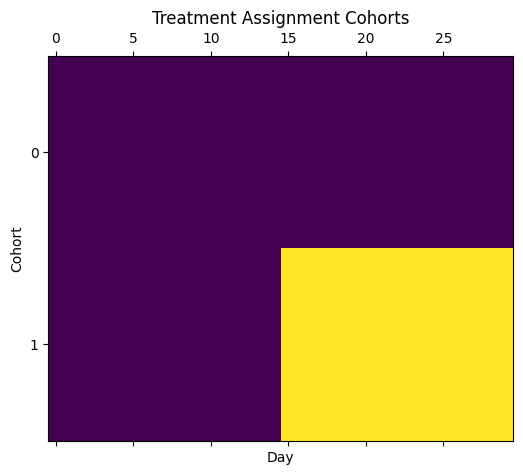

In [3]:
pf.panelview(
    data,
    unit="user",
    time="day",
    treat="treat",
    collapse_to_cohort=True,
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Day",
    title="Treatment Assignment Cohorts",
    figsize=(6, 5),
)

We see that half of our users are treated after half the time. 

In the next step, we will look at three different ways to compute the average treatment effect of our feature on the outcome: 

- First, we will compute a standard "difference in means" estimator and conduct a two-sampled t-test for inference. We do this both by hand and by means of linear regression. While standard, we will show that this estimator is relatively inefficient 
  as it throws aways valuable information from the pre-treatment periods.  
- In a second step, we improve on the difference in means estimator and include pre-treatment measures of the outcome variable to our regression model. In the tech blog world, this method 
  is often referred to as CUPED (which stands for "Controlled-experiment Using Pre-Experiment Data" as far as we know). We will demonstrate that CUPED uted leads to a significant reduction in the variance of our estimators. Pre-treatment averages are a "good control" variable because 
  a) under uncondional randomization, pre-treatment averages should be uncorrelated of the treatment assignment and b) pre-treatment averages should be highly predictive of the post-treatment outcome. The intuition here is simply that users will behave similarly "after" the experiment starts / when receiving the treatment than they did before. 
- In a third step, we show that instead of using pre-treatment averages as a control variable, we can simply fit a panel model and control for user and time fixed effect. 

All three estimators identify the same average treatment effect, but the CUPED and panel estimator are much more efficient: they produce lower variances. 

But first, let's discuss why we are interested in reducing the variance of our estimators. 

## Variance of Estimators, Statistical Power and Sample Size Requirements

In statistical experiments, we care about power to make sure that we detect a true effect. 

It depends on the **signal-to-noise ratio**:

$$
\text{Power} \;\sim\; f\!\left(\frac{|\tau|}{\text{SE}}\right)
$$

where

- $\tau$ = the true effect size  
- $\text{SE} = \frac{\sigma}{\sqrt{n}}$ = the standard error of the estimate  
- $\sigma$ = standard deviation of the outcome  
- $n$ = sample size per group (if balanced)  

So, anything that **increases the effect size**, **increases the sample size**, or **reduces outcome variance** will improve power. That's where our interest in variance reduction stems from. 


## Simple Difference in Means Estimator

The simplest way to analyse an AB test / estimate an average treatment effect is the difference in means estimator:  
$$
    \tau = \frac{1}{n_1} \sum_{i=1}^{n_1} Y_{i,1} - \frac{1}{n_0} \sum_{i=1}^{n_0}  Y_{i,0}
$$

We can compute it in a few lines of `pandas` by implementing three steps: 
- First, we throw away all pre-experimental data. 
- Then, we sum the post-treatment minutes watched into a single data point per user. 
- Finally, we compute the difference of means of total minutes watched between the treated and control group.
Done! 

In [4]:
def _difference_in_means_pd(data):
    # standard analyses: throw away pre-experimental data
    data2 = data.copy()
    data_post = data2[data2.day >= 15]
    # collapse post-treatment minutes watched into a single data point per user
    data_post_agg = (
        data_post.groupby(["user", "treat"])
        .agg({"minutes_watched": "mean"})
        .reset_index()
        .rename(columns={"minutes_watched": "total_minutes_watched"})
    )
    # compute difference of means estimator
    return data_post_agg.groupby("treat").mean().diff()


_difference_in_means_pd(data)

,user,total_minutes_watched
treat,,
0,NaN,NaN
1,-1387.630151,0.761514


Because linear regression is just a fency way to compute and compare differences, we could also have estimated this via `pf.feols()`: 

In [5]:
def _difference_in_means(data):
    data2 = data.copy()

    data_post = data2[data2.day >= 15]
    fit = pf.feols("minutes_watched ~ treat", data=data_post)

    return fit


fit_difference_in_means = _difference_in_means(data)
fit_difference_in_means.summary()

###

Estimation:  OLS
Dep. var.: minutes_watched, Fixed effects: 0
Inference:  iid
Observations:  1500000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.357 |        0.015 |    24.163 |      0.000 |  0.328 |   0.386 |
| treat         |      0.762 |        0.209 |     3.641 |      0.000 |  0.352 |   1.171 |
---
RMSE: 18.07 R2: 0.0 


Note that no aggregation step is needed and that we get identical point estimates. As a bonus, we get standard errors and confidence intervals in the process. 

## Cuped: Using Pre-Experimental Measures of the Outcomes Variable as Controls

Sometimes, throwing away data can be a winning strategy ("garbage in garbage out"), but not in this example: we have high-quality pre-experimental measures of the behavior 
of our users at hand, and we should use it in our favor! 

More specifically, instead of throwing away all of the pre-experimental measures, we could instead have used them as a control! 

This should help reduce the variance of our estimators because pre-experimental behavior is likely to be highly predicitive of what users do after the launch of the experiment. Consequently, including these baselines in our regression models should help us "explain residual errors" and thereby reduce the variance of our 
estimators. 

If this works, it's great news, as it allows us to run the same experiment on a smaller number of users and still achieve the same level of power!

In [6]:
def _regression_cuped(data):
    data = data.copy()
    data["pre_experiment"] = data["day"] < 15

    # aggregate pre-post averages by user
    agg = data.groupby(["user", "pre_experiment"], as_index=False).agg(
        minutes_watched=("minutes_watched", "mean")
    )

    wide = (
        agg.pivot(index="user", columns="pre_experiment", values="minutes_watched")
        .rename(columns={True: "minutes_pre", False: "minutes_post"})
        .reset_index()
    )

    wide = wide.merge(
        data[["user", "ever_treated"]].drop_duplicates(), on="user", how="left"
    ).rename(columns={"ever_treated": "treat"})

    # center the pre metric
    mu_pre = wide["minutes_pre"].mean()
    wide["minutes_pre_c"] = wide["minutes_pre"] - mu_pre

    fit_cuped = pf.feols(
        "minutes_post ~ treat + minutes_pre_c", data=wide, vcov="hetero"
    )

    return fit_cuped, wide


fit_cuped, data_cuped = _regression_cuped(data)

Per user, we now log the total minutes watched before and after the treatment and then fit a regression model of the following form: ^^

$$
    \text{total minutes watched after treatment} = \alpha + \beta \text{treat} + \gamma (\text{total minutes watched before treatment} - \text{avg total minutes watched before treatment}) + \epsilon
$$

In [7]:
data_cuped.head()

,user,minutes_post,minutes_pre,treat,minutes_pre_c
0,0,7.747841,7.767178,0,7.894779
1,1,25.595928,24.674535,0,24.802136
2,2,-32.224392,-32.130334,0,-32.002733
3,3,-12.269762,-13.142435,0,-13.014835
4,4,-1.448348,-1.392043,0,-1.264442


We can compare with the previous results: 

In [8]:
pf.etable([fit_difference_in_means, fit_cuped])

GT(_tbl_data=  level_0             level_1                      0                      1
0    coef               treat  0.762*** <br> (0.209)  0.192*** <br> (0.029)
1    coef       minutes_pre_c                         0.999*** <br> (0.000)
2    coef           Intercept  0.357*** <br> (0.015)  0.360*** <br> (0.002)
3   stats        Observations                1500000                 100000
4   stats           S.E. type                    iid                 hetero
5   stats       R<sup>2</sup>                  0.000                  0.999
6   stats  Adj. R<sup>2</sup>                  0.000                  0.999, _body=<great_tables._gt_data.Body object at 0x0000028E524DB3E0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000028E6AB85610>, _spanners=Spanners([SpannerInfo(spanner_id='minutes_watched', spanner_level=1, spanner_label='minutes_watched', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='minutes_post', spanner_level=1, spanner_label='minutes_post', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000028E6AB84680>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_incl

Point estimates for the difference-in-means estimator is 0.762, while it is 0.192 for the Cuped estimator. But most importantly, the standard errors are much smaller for the CUPED estimator (0.03 vs 0.209). Because we have fitted a regression model with covariates, we have used heteroskedasticity-robust standard errors, which should be more conservative than the iid errors used in the difference-in-means regression.

## Panel Estimator

Instead of collapsing all pre-and post information into a single average (and thereby losing information), we can as well be lazy and just use a panel estimator.

Via `pyfixest`, that's one line of code: 

In [9]:
fit_panel = pf.feols(
    "minutes_watched ~ treat | user + day",
    data=data,
    vcov="hetero",
    demeaner_backend="rust",
)

We can compare all results: 

In [10]:
pf.etable([fit_difference_in_means, fit_cuped, fit_panel])

GT(_tbl_data=  level_0               level_1                      0                      1  \
0    coef                 treat  0.762*** <br> (0.209)  0.192*** <br> (0.029)   
1    coef         minutes_pre_c                         0.999*** <br> (0.000)   
2    coef             Intercept  0.357*** <br> (0.015)  0.360*** <br> (0.002)   
3      fe                   day                      -                      -   
4      fe                  user                      -                      -   
5   stats          Observations                1500000                 100000   
6   stats             S.E. type                    iid                 hetero   
7   stats         R<sup>2</sup>                  0.000                  0.999   
8   stats  R<sup>2</sup> Within                      -                      -   

                       2  
0  0.191*** <br> (0.012)  
1                         
2                         
3                      x  
4                      x  
5                3000000  
6                 hetero  
7                  0.999  
8                  0.000  , _body=<great_tables._gt_data.Body object at 0x0000028E6AAC2690>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000028E6AAC2F30>, _spanners=Spanners([SpannerInfo(spanner_id='minutes_watched', spanner_level=1, spanner_label='minutes_watched', spanner_units=None, spanner_pattern=None, vars=['0', '2'], built=None), SpannerInfo(spanner_id='minutes_post', spanner_level=1, spanner_label='minutes_post', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000028E6AAC2BD0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=T

The panel estimator almost exactly matches CUPED, and we do even better in terms of variance. 

However, because we are working with panel data, the error terms are likely correlated over time within each user. If we ignore this dependence, our standard errors may be underestimated, which in turn can lead to over-rejecting the null hypothesis of no effect. A common way to address this issue is to compute cluster-robust standard errors at the user level, which account for arbitrary heteroskedasticity and autocorrelation within users.

In [11]:
fit_panel_crv = pf.feols(
    "minutes_watched ~ treat | user + day",
    data=data,
    vcov={"CRV1": "user"},
    demeaner_backend="rust",
)

Comparing all results, the panel estimator still does quite well in terms of the size of the estimated standard errors. 

In [12]:
pf.etable(
    [fit_difference_in_means, fit_cuped, fit_panel, fit_panel_crv],
    digits=4,
)

GT(_tbl_data=  level_0               level_1                        0  \
0    coef                 treat  0.7615*** <br> (0.2092)   
1    coef         minutes_pre_c                            
2    coef             Intercept  0.3574*** <br> (0.0148)   
3      fe                   day                        -   
4      fe                  user                        -   
5   stats          Observations                  1500000   
6   stats             S.E. type                      iid   
7   stats         R<sup>2</sup>                   0.0000   
8   stats  R<sup>2</sup> Within                        -   

                         1                        2                        3  
0  0.1918*** <br> (0.0288)  0.1913*** <br> (0.0118)  0.1913*** <br> (0.0287)  
1  0.9992*** <br> (0.0001)                                                    
2  0.3602*** <br> (0.0021)                                                    
3                        -                        x                        x  
4                        -                        x                        x  
5                   100000                  3000000                  3000000  
6                   hetero                   hetero                 by: user  
7                   0.9987                   0.9985                   0.9985  
8                        -                   0.0001                   0.0001  , _body=<great_tables._gt_data.Body object at 0x0000028E52473D10>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000028E6A8F0440>, _spanners=Spanners([SpannerInfo(spanner_id='minutes_watched', spanner_level=1, spanner_label='minutes_watched', spanner_units=None, spanner_pattern=None, vars=['0', '2', '3'], built=None), SpannerInfo(spanner_id='minutes_post', spanner_level=1, spanner_label='minutes_post', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000028E6A8F1D00>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=Options

The panel errors produces point estimates and standard errors for the treatment variable that are very close to CUPED. 

The sceptical reader might now object that this is all far from overwhelming evidence. After all , we fit each model only once! So it might well be 
that we were just lucky and our results are driven by sampling error. In the next section, we will argue that this is not the case by means of a monte carlo simulation. 

### Digression: Heterogeneous Effects over Time via Panel Estimators

One example of the panel estimator is that it allows us to track treatment effects over time. This allows us to track novelty effects where in the beginning, 
users interact a lot with a new feature, i.e. they spend a lot of time playing a gamee, but over time lose interest. 

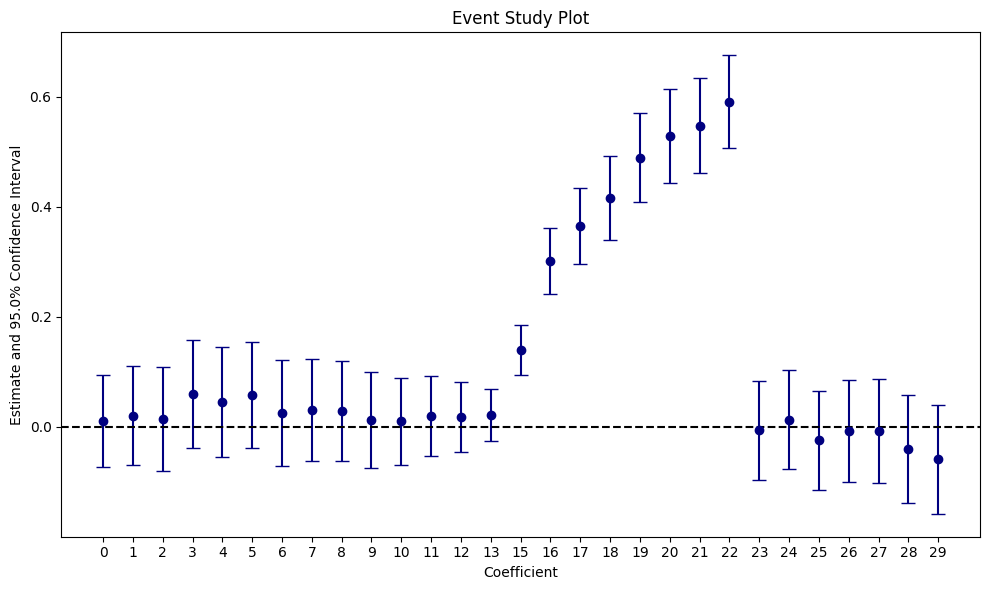

In [13]:
fit_panel_time = pf.feols(
    "minutes_watched ~ i(day, ever_treated, ref = 14) | user + day",
    vcov={"CRV1": "user"},
    data=data,
    demeaner_backend="rust",
)
fit_panel_time.iplot(
    coord_flip=False,
    plot_backend="matplotlib",
    cat_template="{value}",
    title="Event Study Plot",
)

Initially, we observe a large treatment effect that reverts to a null effect on day 23: a clear novelty effect pattern. Clearly, we should not accept this 
experiment as it only adds technical complexity, but has no impact on user behavior beyond the initial effect. When ignoring time heterogeneity (as with the difference in means, cuped, and ATE panel estimators above), we completely miss that the effect fades out. With a dynamic panel estimator, we get it almost for free. 

For more examples, see the paper by [Lal et al](https://arxiv.org/abs/2410.09952), which also shows how to estimate very large panel models in [SQL/duckdb](https://github.com/py-econometrics/duckreg) (yep, that's not a joke!). 

## Monte Carlo Simulation

To rule out that the examples above were purely do to look, we simply repeat them a couple of times using a monte carlo simulation. 

In [14]:
def _variance_monte_carlo(data):
    fit_dim = _difference_in_means(data)
    fit_cuped, _ = _regression_cuped(data)
    fit_panel = pf.feols(
        "minutes_watched ~ treat | user + day",
        data=data,
        vcov={"CRV1": "user"},
        demeaner_backend="rust",
    )

    dim_se = fit_dim.tidy().xs("treat")["Std. Error"]
    cuped_se = fit_cuped.tidy().xs("treat")["Std. Error"]
    panel_se = fit_panel.tidy().xs("treat")["Std. Error"]

    return dim_se, cuped_se, panel_se


def _run_simulation(N, sigma_unit, n_sim=100):
    dim_se_arr = np.zeros(n_sim)
    cuped_se_arr = np.zeros(n_sim)
    panel_se_arr = np.zeros(n_sim)

    for i in tqdm(range(n_sim)):
        data = get_sharkfin(
            num_units=N,
            num_periods=30,
            num_treated=int(N / 2),
            treatment_start=15,
            seed=i,
            sigma_unit=sigma_unit,
        )
        data.rename(
            columns={"Y": "minutes_watched", "unit": "user", "year": "day"},
            inplace=True,
        )

        dim_se_arr[i], cuped_se_arr[i], panel_se_arr[i] = _variance_monte_carlo(data)

    return pd.Series(
        {
            "Difference-in-Means": np.mean(dim_se_arr),
            "Cuped": np.mean(cuped_se_arr),
            "Panel": np.mean(panel_se_arr),
        }
    )

In [ ]:
# note that in a proper scientific simulation, we might want to set the
# number of iterations to be much higher than 10
se_sim_18 = _run_simulation(N=100_000, sigma_unit=18, n_sim=20)
display(se_sim_18)

100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


Difference-in-Means    0.029457
Cuped                  0.004184
Panel                  0.004185
dtype: float64

So we manage to reduce our standard errors by around 6x! This is pretty fantastic news, as it implies that we can run our experiment on a much smaller sample, but still achieve the same level of power! This is what we want to verify in the last step. 

## Power Simulation 

In all simulations, we conduct a two-sided t-test with size $\alpha = 0.01$. 

In [16]:
def _power(nobs, n_sim):
    res_df = pd.DataFrame()

    for N in nobs:
        dim_reject_null_arr = np.zeros(n_sim)
        cuped_reject_null_arr = np.zeros(n_sim)
        panel_reject_null_arr = np.zeros(n_sim)

        for i in tqdm(range(n_sim)):
            data = get_sharkfin(
                num_units=N,
                num_periods=30,
                num_treated=int(N / 2),
                treatment_start=15,
                seed=i,
                sigma_unit=18,
            )
            data.rename(
                columns={"Y": "minutes_watched", "unit": "user", "year": "day"},
                inplace=True,
            )

            fit_dim = _difference_in_means(data)
            fit_cuped, _ = _regression_cuped(data)
            fit_panel = pf.feols(
                "minutes_watched ~ treat | user + day", data=data, vcov={"CRV1": "user"}
            )

            dim_reject_null_arr[i] = fit_dim.pvalue().xs("treat") < 0.01
            cuped_reject_null_arr[i] = fit_cuped.pvalue().xs("treat") < 0.01
            panel_reject_null_arr[i] = fit_panel.pvalue().xs("treat") < 0.01

        dim_reject_null_mean = np.mean(dim_reject_null_arr)
        cuped_reject_null_mean = np.mean(cuped_reject_null_arr)
        panel_reject_null_mean = np.mean(panel_reject_null_arr)

        res = pd.DataFrame(
            {
                "N": [N],
                "Difference-in-Means": [dim_reject_null_mean],
                "Cuped": [cuped_reject_null_mean],
                "Panel": [panel_reject_null_mean],
            }
        )

        res_df = pd.concat([res_df, res], axis=0, ignore_index=True)

    return res_df

In [ ]:
# TODO: set n_sim higher
power_df = _power(nobs=[100, 500, 1000, 5_000, 10_000, 100_000], n_sim=10)

100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


In [ ]:
display(power_df)

,N,Difference-in-Means,Cuped,Panel
0,100,0.5,0.1,0.1
1,500,0.4,0.9,0.9
2,1000,0.7,1.0,1.0
3,5000,0.5,1.0,1.0
4,10000,0.6,1.0,1.0
5,100000,0.9,1.0,1.0


CUPED and the panel estimator achieve 90% power with 500 observations, while the difference in means-estimator requires a sample that is orders of magnitude larger. 
To conclude, we should mention that these effects stem from a stylized exmaple data set - in practice, the gains from CUPED / panel methods for variance reduction are much lower - 
companies with access to high quality panel data report reductions of 10% to 50% (see e.g. this paper by [Microsoft Bing](https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf)).

## When does CUPED not work? 

CUPED only works when we explain a lot of "residual" variation, which in our example data set is controlled by the `sigma_unit` parameter. Let's see what happens if we drastically reduce it - we now change the parameter from `18` to `4`.

We repeat the standard error monte carlo simulation, but set `sigma_unit = 4`.

In [19]:
se_sim_1 = _run_simulation(N=100_000, sigma_unit=4, n_sim=10)

100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


In [22]:
display(se_sim_1)

Difference-in-Means    0.006852
Cuped                  0.004174
Panel                  0.004186
dtype: float64

All of a sudden, the difference-in-means estimator has lower variance!

In [23]:
display(se_sim_18)

Difference-in-Means    0.029457
Cuped                  0.004184
Panel                  0.004185
dtype: float64

The reason we do not achieve variance reduction this time is that the addition of pre-treatment covariates / unit fixed effects simply explains less unobserved variance than before. 

## Other useful links

- [Matteo Courthoud's great blog post on CUPED](https://matteocourthoud.github.io/post/cuped/), goes through some theory, compares CUPED with other estimators, runs simulations studies, and summarizes the literature. 
- [Lal et al on panel experiments](https://arxiv.org/abs/2410.09952) explains why using panel estimators might be a good idea when analysing AB tests, and shows how it can be done efficiently in SQL. 